# Difference-in-Differences Study Case

## Three Billboards in the South of Brazil

Difference-in-Difference, atau diff-in-diff for close friends adalah metode yang biasanya digunakan untuk menilai dampak intervensi makro, seperti dampak imigrasi terhadap pengangguran, dampak perubahan undang-undang senjata terhadap tingkat kejahatan, atau sekadar perbedaan dalam keterlibatan atau engagement user akibat kampanye pemasaran. Dalam semua kasus ini, Anda mempunyai periode sebelum dan sesudah intervensi dan Anda ingin menguraikan dampak intervensi dari tren umum.

Sebagai gambaran ketika suatu perusahaan ingin memasang papang iklan. Memang sekarang sudah banyak iklan digital di media sosial maupun website. Namun iklan konvensional juga berguna sebagai bentuk keragaman marketing. Namun penggunaan iklan konvensional seperti papan baliho memiliki masalah sendiri diantaranya adalah sulitnya mengukur efektifitas atau pengaruh adanya papan iklan terhadap peningkatan sales.

Dibawah adalah contoh penggunaan DiD untuk mengukur pengaruh papan iklan terhadap pemasaran. Data diambil dari buku *Causal Inference for The Brave and True*. Terdapat 3 baliho di kota Porto Alegre, ibu kota negara bagian Rio Grande do Sul. Kami ingin melihat apakah hal itu meningkatkan simpanan ke rekening tabungan. Sebagai catatan bagi mereka yang belum terlalu paham dengan geografi Brasil, Rio Grande do Sul adalah bagian selatan negara itu, salah satu kawasan paling maju.

Sebagai pembanding diperlukan data dari ibu kota lain di selatan, Florianopolis, ibu kota negara bagian Santa Catarina. Idenya adalah kita dapat menggunakan Florianopolis sebagai sampel kontrol untuk memperkirakan kontrafaktual $Y_0$ bila dibandingkan dengan Porto Alegre (omong-omong, ini bukanlah eksperimen sebenarnya dan bersifat rahasia, namun idenya sangat mirip). Papan reklame dipasang di Porto Alegre sepanjang bulan Juni. Data terlihat seperti ini:

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
from matplotlib import style
from matplotlib import pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf


%matplotlib inline

style.use("fivethirtyeight")

In [3]:
data = pd.read_csv("billboard_impact.csv")
data

,deposits,poa,jul
0,42,1,0
1,0,1,0
2,52,1,0
3,119,1,0
4,21,1,0
...,...,...,...
4595,195,0,1
4596,231,0,1
4597,270,0,1
4598,343,0,1


simpanan/deposits = variabel hasil, yang ingin kita tingkatkan dengan papan reklame.

POA = indikator dummy untuk kota Porto Alegre. 0=  Florianopolis.

Jul = dummy untuk bulan Juli, atau untuk periode pasca intervensi. 0 = bulan Mei, periode sebelum intervensi.

## DID Estimator

Misalkan $Y_D(T)$ adalah hasil potensial untuk treatment D pada periode T. Dalam dunia ideal di mana kita memiliki kemampuan untuk mengamati kontrafaktual, kita akan memperkirakan efek treatment dari suatu intervensi dengan cara berikut:

$
\hat{ATET} = E[Y_1(1) - Y_0(1)|D=1]
$

Dengan kata lain, efek kausal adalah hasil pada periode pasca intervensi jika ada treatment dikurangi hasil pada periode setelah intervensi, namun jika tidak ada treatment. Tentu saja, kami tidak dapat mengukurnya karena $Y_0(1)$ bersifat kontrafaktual.

Salah satu cara menyiasatinya adalah dengan membandingkan sebelum dan sesudah.

$
\hat{ATET} = E[Y(1)|D=1] - E[Y(0)|D=1]
$

Dalam contoh kita, kita akan membandingkan rata-rata deposit dari POA sebelum dan sesudah billboard dipasang.

In [11]:
poa_before = data.query("poa==1 & jul==0")["deposits"].mean()

poa_after = data.query("poa==1 & jul==1")["deposits"].mean()

poa_after - poa_before

41.04775

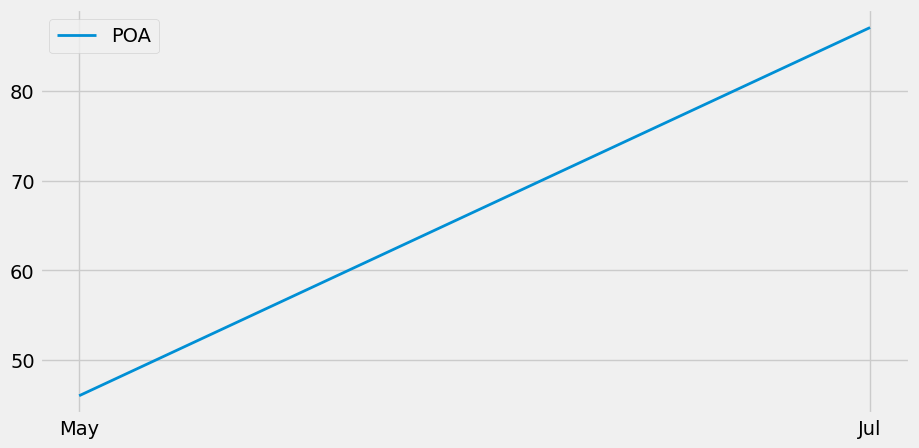

In [12]:
plt.figure(figsize=(10,5))
plt.plot(["May", "Jul"], [poa_before, poa_after], label="POA", lw=2)

plt.legend();

Estimator ini memberi tahu kita bahwa kita harus memperkirakan simpanan akan meningkat sebesar R$ 41,04 setelah intervensi. Tapi bisakah kita mempercayai ini?

persamaan sebelumnya mengasumsikan tidak adanya tren yang mana hal ini sangat jarang terjadi pada data yang memiliki variabel waktu. Karena bisa jadi periode setelah intervensi memiliki nilai yang lebih besar $E[Y_0(1)|D=1] > E[Y_0(0)|D=1]$ atau lebih kecil $E[Y_0(1)|D=1] < E[Y_0(0)|D=1]$. Hal ini untuk menunjukkan bahwa hal sebelum dan sesudah ini bukanlah penduga yang baik.

Ide lainnya adalah membandingkan kelompok yang diberi treatment dengan kelompok yang tidak diberi treatment dan tidak mendapatkan intervensi:

$
\hat{ATET} = E[Y(1)|D=1] - E[Y(1)|D=0]
$

Dalam contoh kita, kita akan membandingkan simpanan dari POA dengan simpanan di Florianopolis pada periode pasca intervensi.

In [5]:
fl_after = data.query("poa==0 & jul==1")["deposits"].mean()
poa_after - fl_after

-119.10175000000001

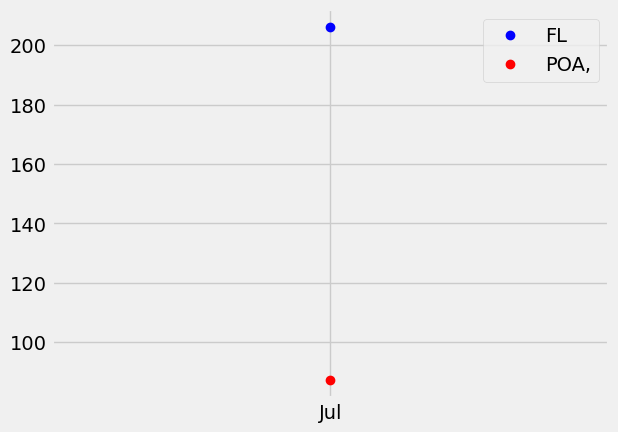

In [44]:
plt.plot([ "Jul"], [ fl_after], 'bo', label="FL")
plt.plot([ "Jul"], [ poa_after], 'ro', label="POA,")

plt.legend();

Penaksir ini memberi tahu kita bahwa kampanye ini merugikan dan pelanggan akan menurunkan simpanan sebesar R$ 119,10.

Kita menggunakan $E[Y(1)|D=0]$ atau control sebelum intervensi untuk memperkirakan kontrafaktual treatment atau $E[Y_0(1)|D =0] = E[Y_0(1)|D=1]$. Ini bisa saja digunakan jika kedua kelompok memiliki tingkat dasar yang sangat mirip. Misalnya, jika Florianopolis memiliki simpanan yang jauh lebih banyak daripada Porto Alegre, hal ini tidak benar karena $E[Y_0(1)|D=0] > E[Y_0(1)|D=1]$. Di sisi lain, jika tingkat simpanan di Florianopolis lebih rendah, kita akan memiliki $E[Y_0(1)|D=0] < E[Y_0(1)|D=1]$.

Sekali lagi, ini bukanlah ide bagus. Untuk mengatasi hal ini, kita dapat menggunakan perbandingan ruang dan waktu untuk mengganti kontrafaktual yang hilang dengan cara berikut:

$
E[Y_0(1)|D=1] = E[Y_0(0)|D=1] + (E[Y_0(1)|D=0] - E[Y_0(0)|D=0])
$

Hal ini dilakukan dengan mengambil unit yang diberi treatment **sebelum intervensi** dan menambahkan komponen tren ke dalamnya, yang diperkirakan menggunakan kontrol $E[Y_0(1)|D=0] - E[Y_0(0)|D =0]$. Dengan kata lain, hal yang diberi treatment **setelah intervensi**, jika tidak diberi treatment, akan terlihat seperti **yang diberi treatment sebelum treatment** ditambah faktor pertumbuhan yang sama dengan pertumbuhan kontrol (atau tren waktu).

Penting untuk dicatat bahwa hal ini mengasumsikan bahwa tren dalam treatment dan control adalah sama:

$
E[Y_0(1) − Y_0(0)|D=1] = E[Y_0(1) − Y_0(0)|D=0]
$

dimana sisi kiri adalah tren kontrafaktual. Sekarang, kita dapat mengganti perkiraan kontrafaktual dalam definisi efek treatment $E[Y_1(1)|D=1] - E[Y_0(1)|D=1]$

$
\hat{ATET} = E[Y(1)|D=1] - (E[Y(0)|D=1] + (E[Y(1)|D=0] - E[Y(0) |H=0])
$

Jika kita menyusun ulang suku-sukunya, kita mendapatkan estimator Diff-in-Diff klasik.

$
\hat{ATET} = (E[Y(1)|D=1] - E[Y(1)|D=0]) - (E[Y(0)|D=1] - E[Y(0 )|H=0])
$

Dinamakan demikian karena mendapat perbedaan antara treatment dan kontrol setelah dan sebelum perlakuan.

Inilah yang terlihat dalam kode.

In [6]:
fl_before = data.query("poa==0 & jul==0")["deposits"].mean()

diff_in_diff = (poa_after-poa_before)-(fl_after-fl_before)
diff_in_diff

6.524557692307688

Diff-in-Diff memberi tahu kita bahwa kita harus memperkirakan simpanan meningkat sebesar R$ 6,52 per pelanggan. Perhatikan bahwa asumsi yang dibuat diff-in-diff jauh lebih masuk akal dibandingkan 2 penduga lainnya. Diasumsikan saja pola pertumbuhan kedua kota tersebut sama. Namun hal ini tidak mengharuskan keduanya memiliki tingkat dasar yang sama dan juga tidak mengharuskan tren menjadi nol.

Untuk memvisualisasikan apa yang dilakukan diff-in-diff, kita dapat memproyeksikan tren pertumbuhan dari yang tidak diberi perlakuan ke yang diberi perlakuan untuk melihat kontrafaktualnya, yaitu jumlah simpanan yang diharapkan jika tidak ada intervensi.

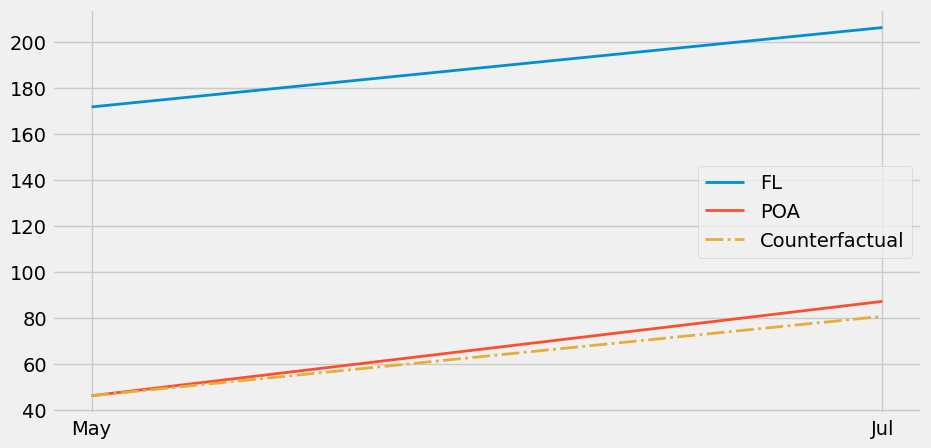

In [7]:
plt.figure(figsize=(10,5))
plt.plot(["May", "Jul"], [fl_before, fl_after], label="FL", lw=2)
plt.plot(["May", "Jul"], [poa_before, poa_after], label="POA", lw=2)

plt.plot(["May", "Jul"], [poa_before, poa_before+(fl_after-fl_before)],
         label="Counterfactual", lw=2, color="C2", ls="-.")

plt.legend();

Terdapat perbedaan kecil antara garis putus-putus merah dan kuning ini adalah efek kecil treatment di Porto Alegre.

Untuk melihat standar error kita akan menggunakan model linier berikut

$
Y_i = \beta_0 + \beta_1 POA_i + \beta_2 Juli_i + \beta_3 POA_i*Jul_i + e_i
$

$\beta_0$ adalah garis dasar kontrol. Dalam kasus kami, adalah tingkat simpanan di Florianopolis pada bulan Mei.

Jadi $\beta_0 + \beta_1$ adalah garis dasar Porto Alegre pada bulan Mei, sebelum intervensi. 

$\beta_1$ adalah kenaikan yang kita dapatkan dari kontrol ke yang diberi treatment, 

$\beta_2$ adalah kenaikan yang kita dapatkan dari periode sebelum ke periode setelah intervensi. 

Terakhir, jika kita mengaktifkan kedua dummy tersebut, kita mendapatkan $\beta_3$. $\beta_0 + \beta_1 + \beta_2 + \beta_3$ adalah level di Porto Alegre setelah intervensi. Jadi $\beta_3$ adalah dampak tambahan saat Anda bepergian dari Mei hingga Juli dan dari Florianopolis ke POA. Dengan kata lain, ini adalah penduga Differennce in Difference.

In [8]:
smf.ols('deposits ~ poa*jul', data=data).fit().summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,171.6423,2.363,72.625,0.000,167.009,176.276
poa,-125.6263,4.484,-28.015,0.000,-134.418,-116.835
jul,34.5232,3.036,11.372,0.000,28.571,40.475
poa:jul,6.5246,5.729,1.139,0.255,-4.706,17.755


## Tren Non Paralel

Salah satu masalah nyata dengan Diff-in-Diff adalah kegagalan memenuhi asumsi tren paralel. Jika tren pertumbuhan dari wilayah yang diberi perlakuan berbeda dengan tren di wilayah kontrol, maka diff-in-diff akan menjadi bias. 

Salah satu cara untuk memeriksa apakah hal ini terjadi adalah dengan menggambar tren menggunakan periode yang lalu. Sebagai contoh, mari kita asumsikan POA memiliki tren penurunan yang kecil namun Florianopolis mengalami peningkatan yang tajam. Dalam kasus ini, menunjukkan periode sebelumnya akan mengungkapkan tren tersebut dan kita akan mengetahui bahwa Diff-in-Diff bukanlah penduga yang dapat diandalkan.

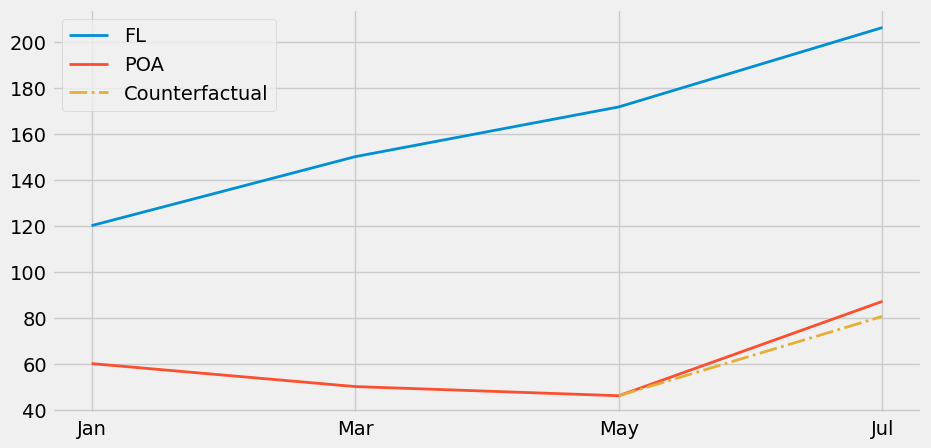

In [9]:
plt.figure(figsize=(10,5))
x = ["Jan", "Mar", "May", "Jul"]

plt.plot(x, [120, 150, fl_before,  fl_after], label="FL", lw=2)
plt.plot(x, [60, 50, poa_before, poa_after], label="POA", lw=2)

plt.plot(["May", "Jul"], [poa_before, poa_before+(fl_after-fl_before)], label="Counterfactual", lw=2, color="C2", ls="-.")

plt.legend();

## Referensi

https://matheusfacure.github.io/python-causality-handbook/13-Difference-in-Differences.html

[GitHub](https://github.com/matheusfacure/python-causality-handbook/stargazers).

Jika Anda menganggap buku diatas berharga dan ingin mendukungnya, silakan kunjungi [Patreon](https://www.patreon.com/causal_inference_for_the_brave_and_true).